# Salamander User Guide

Salamander is a non-negative matrix factorization (NMF) framework for mutational signature analysis build on top of [AnnData](https://anndata.readthedocs.io/en/latest/) and [MuData](https://mudata.readthedocs.io/en/latest/).

This user guide consists of two examples. The first one is an explorative data analysis of 311 breast cancer samples with known homologous repair (HR) status from [HRDetect](https://www.nature.com/articles/nm.4292). The second one demonstrates how to use Salamander for a multimodal mutational signature analysis (under developement).
<br>
All NMF models implemented in Salamander support fixing arbitrary many a priori known signatures and learning the remaining ones. We demonstrate this feature in both examples.

In general, results from a single NMF run should be interpreted with caution as the algorithms are well-known to get stuck in local optima. The package should therefore be used as a toolkit for explorative data analysis or as the base software of more comprehensive pipelines. 

In [1]:
import anndata as ad
import mudata as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import salamander as sal

# 1. Explorative breast cancer data analysis

## 1.1 Data preparation

The key functionality of AnnData is to store arbitrary sample and mutation type annotations in the same data container. Keeping track of all information in one place is incredibly useful for saving data and plotting.

We start by loading the mutation counts and the HR information into one AnnData object. Notice that samples in AnnData objects correspond to rows instead of columns, which is different from the current standard in mutational signature analysis.

In [2]:
data_path = "data"

In [3]:
counts = pd.read_csv(f"{data_path}/hrdetect_counts_training.csv", index_col=0).T
adata = ad.AnnData(counts)
adata.to_df().head()

Type,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
PD10014a,235,241,37,234,244,238,35,243,146,126,...,70,107,32,18,61,78,71,54,76,160
PD11327a,281,229,53,260,284,219,46,264,199,144,...,106,78,28,22,50,55,84,48,111,184
PD11742a,117,100,10,104,113,119,20,101,82,66,...,28,43,12,7,24,27,39,23,51,70
PD11748a,232,178,12,227,230,215,32,207,155,108,...,90,96,38,29,80,72,66,45,106,134
PD11750a,105,92,18,103,129,103,20,131,68,51,...,59,62,25,19,49,38,66,49,71,120


In [4]:
hr_labels = pd.read_csv(f"{data_path}/hrdetect_labels_training.csv", index_col=0)
hr_labels.head()

,hrdetect_score,hrd_label
PD10014a,0.992116,1
PD11327a,0.743665,1
PD11742a,0.999670,1
PD11748a,0.996082,1
PD11750a,0.845486,1


In [5]:
# attach HR information to AnnData object
adata.obs["hrdetect_score"] = hr_labels["hrdetect_score"]
adata.obs["hrd_label"] = hr_labels["hrd_label"]
adata

AnnData object with n_obs × n_vars = 311 × 96
    obs: 'hrdetect_score', 'hrd_label'

In [6]:
adata.obs.head()

,hrdetect_score,hrd_label
PD10014a,0.992116,1
PD11327a,0.743665,1
PD11742a,0.999670,1
PD11748a,0.996082,1
PD11750a,0.845486,1


Let us also load the [COSMIC catalog](https://cancer.sanger.ac.uk/signatures/sbs/) of single base substitution (SBS) mutational signatures. It will be useful for fixing known signatures during model training and comparing denovo signatures to published mutational patterns.

In [7]:
catalog_sbs = pd.read_csv(f"{data_path}/COSMIC_v3.3.1_SBS_GRCh38.csv", index_col=0).T
catalog_sbs.head()

Type,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
SBS1,8.760229e-04,0.002220,0.000180,0.001265,0.000305,0.001738,9.195448e-05,2.180221e-16,0.001556,3.293192e-04,...,0.000126,0.000169,2.179179e-16,2.184121e-16,0.000344,1.455855e-05,2.165410e-16,0.000055,0.000578,2.201263e-16
SBS2,5.790059e-07,0.000146,0.000054,0.000098,0.000205,0.000093,2.221443e-16,4.155765e-04,0.000086,2.187235e-16,...,0.000120,0.000203,2.062090e-04,1.315215e-04,0.000037,2.245140e-16,1.637288e-05,0.000071,0.000095,2.222518e-16
SBS3,2.091975e-02,0.016343,0.001808,0.012265,0.022376,0.024992,2.519081e-03,1.531538e-02,0.007144,1.077098e-02,...,0.010698,0.007075,4.393612e-03,2.331305e-03,0.010949,5.913508e-03,7.161182e-03,0.006401,0.008113,1.054309e-02
SBS4,4.245074e-02,0.032990,0.016116,0.029663,0.080269,0.078743,2.459315e-02,6.863345e-02,0.031667,3.439439e-02,...,0.003790,0.001208,5.945388e-04,2.521062e-04,0.002441,2.556565e-04,3.724498e-04,0.000177,0.002339,5.704354e-04
SBS5,1.205205e-02,0.009337,0.001908,0.006636,0.007379,0.006057,3.467616e-03,6.445227e-03,0.010205,7.548778e-03,...,0.006120,0.007336,2.501419e-03,1.701241e-03,0.005316,2.380296e-03,5.148772e-03,0.006677,0.006984,1.353626e-02


## 1.2 Training a model

For simplicity, we now set the number of signatures to be equal to six. A heuristic way to select the number of signatures with Salamander can be found at the end of the this section.

In [8]:
n_signatures = 6

# NMF with Poisson noise
model = sal.models.KLNMF(n_signatures=n_signatures, init_method="random")
model.fit(adata.copy(), init_kwargs={"seed": 42})

Fitting an NMF model learns the underlying mutational signatures and their exposures to the samples. The signatures can be accessed as an AnnData object of the model via $\texttt{model.asignatures}$

In [9]:
model.asignatures.to_df().head()

Type,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Sig1,0.019787,1.860484e-02,0.003175,1.902114e-02,0.018502,0.019350,0.002554,0.017063,0.008046,0.011090,...,0.010854,0.009339,4.483434e-03,3.171670e-03,7.859385e-03,6.968846e-03,9.256610e-03,0.006410,0.010971,0.015336
Sig2,0.000550,1.192093e-07,0.000352,1.523354e-07,0.002150,0.001476,0.000539,0.001907,0.002127,0.000161,...,0.000541,0.000515,1.192093e-07,1.192093e-07,1.192093e-07,1.192093e-07,9.268081e-04,0.000372,0.000253,0.001709
Sig3,0.013855,1.109985e-02,0.002502,5.735804e-03,0.005803,0.002638,0.001959,0.003051,0.014460,0.006245,...,0.001242,0.001445,5.181981e-04,1.115916e-03,1.020352e-03,1.081934e-03,4.212582e-03,0.003180,0.003345,0.009378
Sig4,0.008160,1.007933e-02,0.001582,7.107403e-03,0.005220,0.010155,0.001172,0.006484,0.000454,0.007829,...,0.006013,0.004285,2.583766e-03,1.630097e-03,5.023175e-03,3.705892e-03,7.168212e-03,0.003792,0.005900,0.013807
Sig5,0.039931,2.630000e-02,0.003048,2.614050e-02,0.042771,0.021901,0.006080,0.037041,0.043029,0.017723,...,0.002889,0.024221,1.154597e-03,2.904535e-04,1.302309e-03,6.707409e-03,1.192093e-07,0.000895,0.002604,0.011154


and the exposures are added as multidimensional annotations to the $\texttt{model.adata}$ AnnData object.

In [10]:
model.adata

AnnData object with n_obs × n_vars = 311 × 96
    obs: 'hrdetect_score', 'hrd_label'
    obsm: 'exposures'

In [11]:
model.adata.obsm["exposures"].shape

(311, 6)

Alternatively, the fitted signatures and exposures can be accessed as pandas dataframes via $\texttt{model.signatures}$ and $\texttt{model.exposures}$.

Before visualizing the signatures and exposures, it is useful to perform a sanity check by assessing the convergence of the algorithm.

<Axes: xlabel='n_iteration', ylabel='objective function value'>

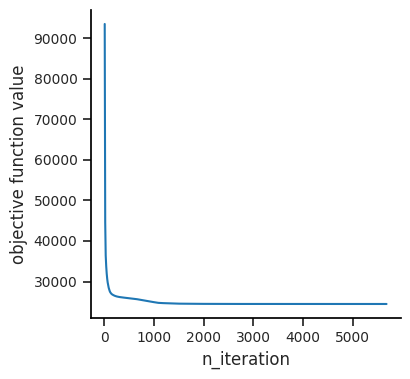

In [12]:
model.plot_history()

## 1.3 Visualizing results

Salamander comes with an extensive functionality to plot the signatures, the exposures, their correlation, or any annotations stored in $\texttt{adata.obs}$ and $\texttt{adata.obsm}$.

### 1.3.1 Explicit API

array([<Axes: title={'center': 'Sig1'}>, <Axes: title={'center': 'Sig2'}>,
       <Axes: title={'center': 'Sig3'}>, <Axes: title={'center': 'Sig4'}>,
       <Axes: title={'center': 'Sig5'}>, <Axes: title={'center': 'Sig6'}>],
      dtype=object)

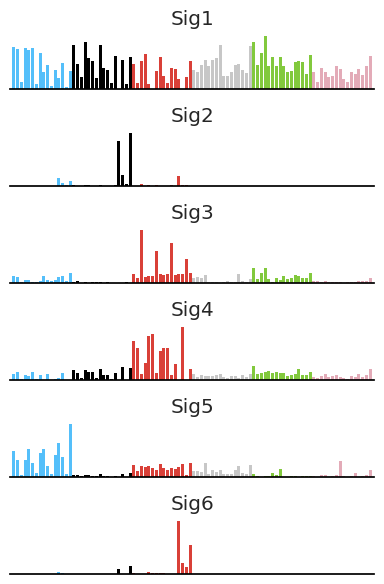

In [13]:
sal.pl.barplot(model.asignatures)

<Axes: title={'center': 'Stacked barplot of the signature exposures'}>

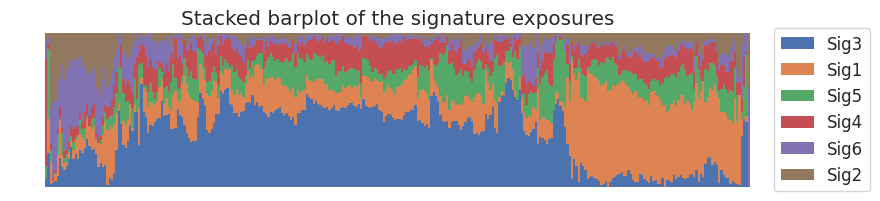

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

ax.set_title("Stacked barplot of the signature exposures")
sal.pl.stacked_barplot(model.exposures, annotate_obs=False, ax=ax)

In addition to plotting the relative exposures, it is possible to visualize a dimensionality reduction of the absolute exposures.

In [15]:
# use 'tool' module to compute and store dimensionality reduction
sal.tl.reduce_dimension(
    model.adata,
    basis="exposures",  # adata.obsm key
    method="umap",
    n_components=3
)
model.adata

AnnData object with n_obs × n_vars = 311 × 96
    obs: 'hrdetect_score', 'hrd_label'
    obsm: 'exposures', 'X_umap'

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

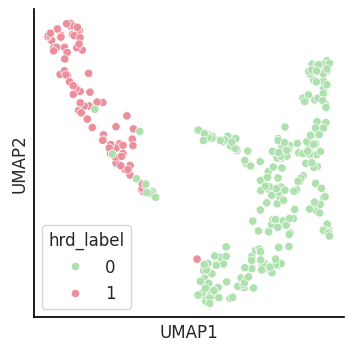

In [16]:
palette = ["#afe1af", "#ec8f9c"]

sal.pl.embedding(
    model.adata,
    basis="umap",
    hue=adata.obs["hrd_label"],
    palette=palette
)

Instead of using a hue and a palette, it is also possible to add colors to the AnnData container explicitly and to refer to them when calling the embedding plot. Another useful feature of the embedding plot is to annotate some data points. By default, the annotations are adjusted to prevent any overlap.

<Axes: xlabel='UMAP1', ylabel='UMAP3'>

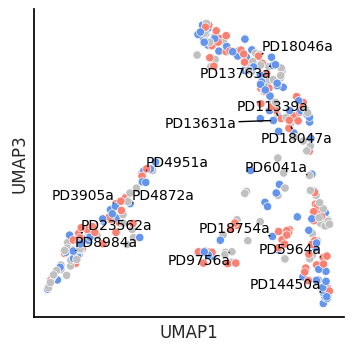

In [17]:
# nonsensical colors and annotations
my_colors = ["cornflowerblue", "silver", "salmon"]
model.adata.obs["my_color"] = np.random.choice(my_colors, adata.n_obs)

special_samples = np.random.choice(adata.obs_names, 15)
annotations = [
    sample if sample in special_samples else ""
    for sample in adata.obs_names
]

sal.pl.embedding(
    model.adata,
    "umap",
    dimensions=[0,2],  # first and third UMAP component
    color="my_color",
    annotations=annotations,
    adjust_kwargs={"arrowprops": dict(arrowstyle="-", color='k')},  # add arrows to annoations
)

Importantly, the embedding plot can be used to visualize _any_ multidimensional sample annotation. In particular, we can also plot a scatterplot of the exposures of two signatures.

<Axes: xlabel='Sig1', ylabel='Sig3'>

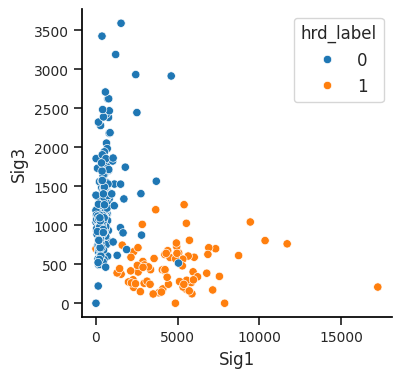

In [18]:
sal.pl.embedding(
    model.adata,
    basis="exposures",
    dimensions=[0,2],  # zero-indexed
    xlabel=model.signature_names[0],
    ylabel=model.signature_names[2],
    hue=adata.obs["hrd_label"]
)

Analogous to plotting multidimensional annotations via $\texttt{sal.pl.embedding()}$, one-dimensional annotations stored in $\texttt{adata.obs}$ can be visualized with $\texttt{sal.pl.scatter()}$.

<Axes: xlabel='hrd_label', ylabel='hrdetect_score'>

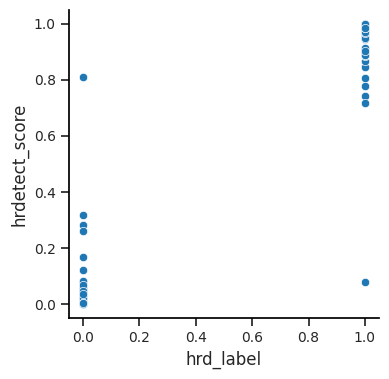

In [19]:
sal.pl.scatter(model.adata, x="hrd_label", y="hrdetect_score")

In [20]:
# compute and store Pearson correlation based on exposures
sal.tl.correlation(model.adata, "exposures")
model.adata

AnnData object with n_obs × n_vars = 311 × 96
    obs: 'hrdetect_score', 'hrd_label', 'my_color'
    obsm: 'exposures', 'X_umap'
    obsp: 'X_correlation'

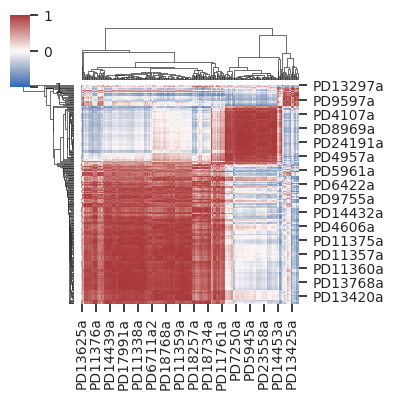

In [21]:
# visualize correlation
sal.pl.correlation(model.adata)

Plotting the signature correlation requires to use the implicit API (see below) because the signatures and signature exposures are stored in two different AnnData objects.

### 1.3.2 Implicit API

'Implicit' here refers to calling methods of the NMF model rather than calling functions from $\texttt{sal.tl}$ and $\texttt{sal.pl}$ explicitly.

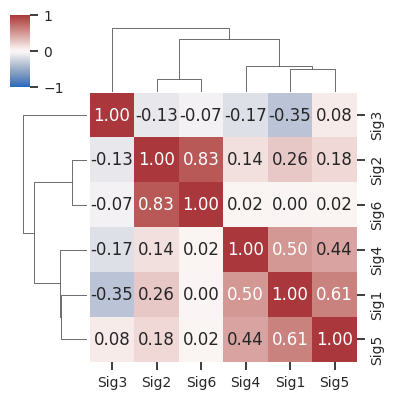

In [22]:
model.plot_correlation(data="signatures")

For convenience, NMF models also come with wrappers for all other plotting functions.

array([[<Axes: title={'center': 'Sig1'}>,
        <Axes: title={'center': 'SBS3'}>],
       [<Axes: title={'center': 'Sig2'}>,
        <Axes: title={'center': 'SBS13'}>],
       [<Axes: title={'center': 'Sig3'}>,
        <Axes: title={'center': 'SBS1'}>],
       [<Axes: title={'center': 'Sig4'}>,
        <Axes: title={'center': 'SBS30'}>],
       [<Axes: title={'center': 'Sig5'}>,
        <Axes: title={'center': 'SBS18'}>],
       [<Axes: title={'center': 'Sig6'}>,
        <Axes: title={'center': 'SBS2'}>]], dtype=object)

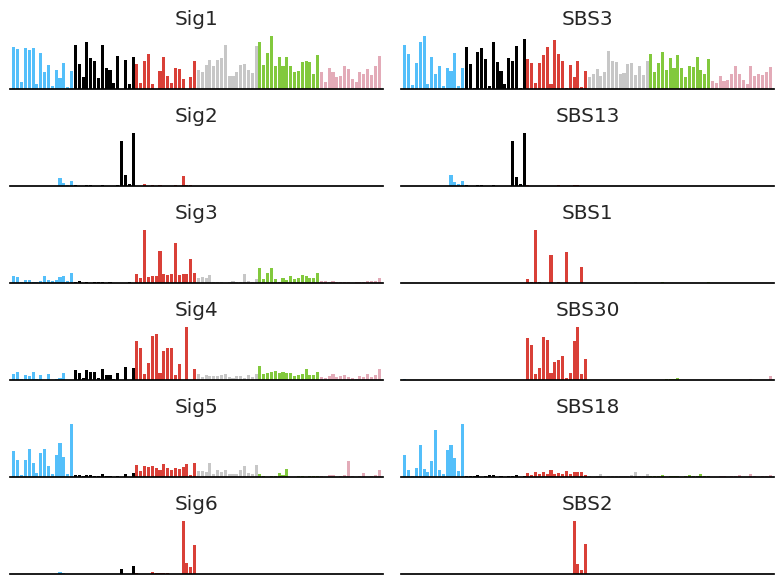

In [23]:
# also find the closest COSMIC match
model.plot_signatures(catalog=catalog_sbs)

<Axes: >

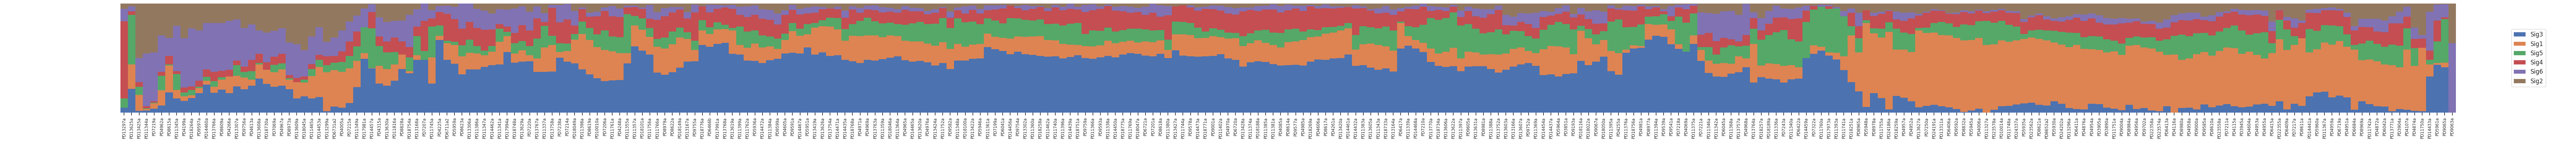

In [24]:
model.plot_exposures()

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

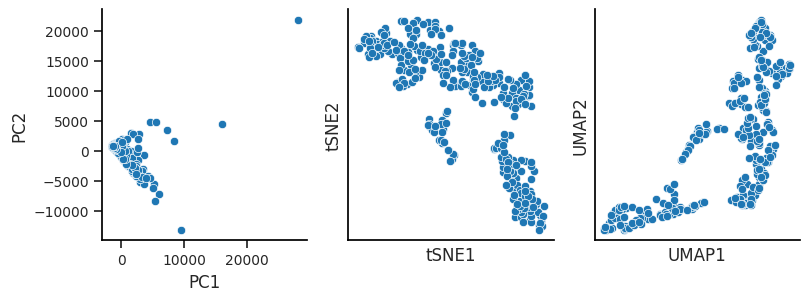

In [25]:
# PCA, t-SNE or UMAP of the sample exposures
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

model.plot_embeddings(method="pca", ax=axes[0])
model.plot_embeddings(method="tsne", ax=axes[1])
model.plot_embeddings(method="umap", ax=axes[2])

Notice that $\texttt{model.plot\_embeddings()}$ still calls the explicit API internally, so the lower-dimensional coordinates will be stored in the AnnData object.

In [26]:
model.adata

AnnData object with n_obs × n_vars = 311 × 96
    obs: 'hrdetect_score', 'hrd_label', 'my_color'
    obsm: 'exposures', 'X_umap', 'X_pca', 'X_tsne'
    obsp: 'X_correlation'

## 1.4 Fixing a priori known signatures

Salamander supports fixing arbitrary many a priori known signatures during model training. However, only learning a subset of the signatures might cause NMF algorithms to get stuck in poor local optima. We recommend to track the objective function values and to compare them to runs where no signatures are fixed.

In [27]:
known_signatures = catalog_sbs.loc[["SBS1", "SBS13"]]
given_parameters = {"asignatures": ad.AnnData(known_signatures)}

array([<Axes: title={'center': 'SBS1'}>,
       <Axes: title={'center': 'SBS13'}>,
       <Axes: title={'center': 'Sig1'}>, <Axes: title={'center': 'Sig2'}>],
      dtype=object)

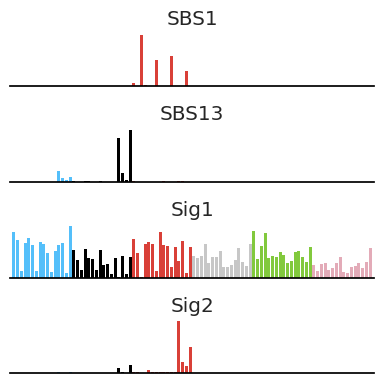

In [28]:
model = sal.models.KLNMF(n_signatures=4)
model.fit(adata.copy(), given_parameters=given_parameters)
model.plot_signatures()

## 1.5 Other NMF models

The syntax for minimum volume NMF and correlated NMF is identical, and fixing a priori known signatures is supported too. In this tutorial, we only run these algorithms for 10 iterations because of their longer runtime.

**Note**: The first iteration of an algorithm takes a little longer because the update rules of the parameters are just-in-time compiled with [numba](https://numba.pydata.org/). All subsequent iterations are much faster.

In [29]:
model_mvnmf = sal.models.MvNMF(
    n_signatures=n_signatures,
    lam=1,  # volume penalty hyperparameter
    max_iterations=10
)
model_mvnmf.fit(adata.copy())

In [30]:
model_corrnmf = sal.models.CorrNMFDet(
    n_signatures=n_signatures,
    dim_embeddings=4,  # common embedding dimension of signatures and samples
    max_iterations=10
)
model_corrnmf.fit(adata.copy())

Compared to KL-NMF, it is important to keep in mind that correlated NMF learns signature and sample embeddings in a shared embedding space. When computing and visualizing a dimenionality reduction of the embeddings, it is therefore necessary to consider $\texttt{model\_corrnmf.adata}$ and $\texttt{model\_corrnmf.asignatures}$ jointly.

In [31]:
model_corrnmf.adata

AnnData object with n_obs × n_vars = 311 × 96
    obs: 'hrdetect_score', 'hrd_label', 'scalings'
    obsm: 'embeddings', 'exposures'

In [32]:
model_corrnmf.asignatures

AnnData object with n_obs × n_vars = 6 × 96
    obs: 'scalings'
    obsm: 'embeddings'

In [33]:
sal.tl.reduce_dimension_multiple(
    [model_corrnmf.adata, model_corrnmf.asignatures],
    basis="embeddings",
    method="umap",
)

The lower-dimensional representations of the embeddings are now added to both AnnData objects.

In [34]:
model_corrnmf.adata.obs["color"] = adata.n_obs *  ["#afe1af"]
model_corrnmf.asignatures.obs["color"] = model_corrnmf.n_signatures * ["black"]

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

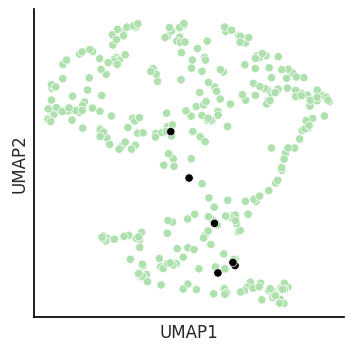

In [35]:
sal.pl.embedding_multiple(
    [model_corrnmf.adata, model_corrnmf.asignatures],
    "umap",
    color="color"
)

The implicit API does all of these steps automatically and also adds annotations to the signature embeddings.

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

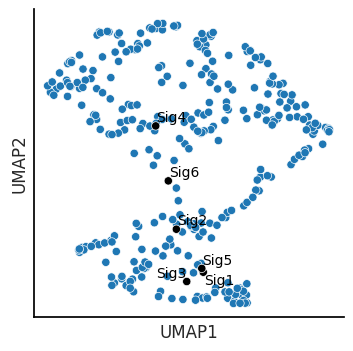

In [36]:
model_corrnmf.plot_embeddings()

## 1.6 Heuristic selection of the number of signatures

The number of signatures can be selected heuristically by running NMF for different numbers of signatures and assessing the decay of the reconstruction error. A reasonable choice should correspond to an 'elbow' in the plot of the decreasing reconstruction error.

In [37]:
ns_signatures = np.arange(1, 10)
models = []

for n_signatures in ns_signatures:
    print(f"Running NMF for {n_signatures} signatures.")
    model = sal.models.KLNMF(n_signatures=n_signatures)
    model.fit(adata.copy())
    models.append(model)

Running NMF for 1 signatures.
Running NMF for 2 signatures.
Running NMF for 3 signatures.
Running NMF for 4 signatures.
Running NMF for 5 signatures.
Running NMF for 6 signatures.
Running NMF for 7 signatures.
Running NMF for 8 signatures.
Running NMF for 9 signatures.


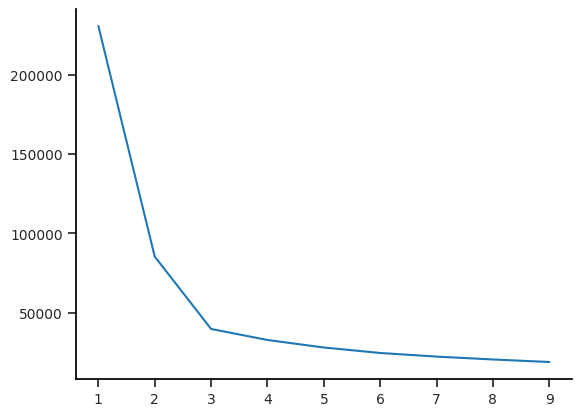

In [38]:
reconstruction_errors = [model.reconstruction_error for model in models]

plt.plot(ns_signatures, reconstruction_errors)

We can see that three components are sufficient to explain most of the signal in the dataset. However, no normalization of the count matrix was performed in a preprocessing step and no outlier samples were removed. The decay of the reconstruction error might for example be strongly influenced by a small number of signatures causing a lot of variants. In particular, this does not rule out the existence of other mutational processes.

When selecting the number of signatures at an exploratory stage, we encourage the user to try different preprocessing steps and to run multiple NMF models.

# 2. Multimodal correlated NMF

Multimodal correlated NMF can process multiple modalities at once assuming that the input data of each modality originates from the identical samples. In the multimodal regime, the base data structure is MuData&#151;a multimodal extension of AnnData.

## 2.1 Data preparation

In [39]:
counts_sbs = pd.read_csv(f"{data_path}/pcawg_breast_sbs.csv", index_col=0).T
adata_sbs = ad.AnnData(counts_sbs)

counts_indel = pd.read_csv(f"{data_path}/pcawg_breast_indel.csv", index_col=0).T
adata_indel = ad.AnnData(counts_indel)

# initialize multimodal data container
mdata = md.MuData({"SBS": adata_sbs, "Indel": adata_indel})
mdata

MuData object with n_obs × n_vars = 192 × 179
  2 modalities
    SBS:	192 x 96
    Indel:	192 x 83

In [40]:
catalog_indel = pd.read_csv(f"{data_path}/COSMIC_v3.4_ID_GRCh37.txt", index_col=0).T
catalog_indel.columns = counts_indel.columns  # unify feature names

## 2.2 Training the model

In [41]:
model = sal.models.MultimodalCorrNMF(
    ns_signatures=[5,4],
    dim_embeddings=6,
    max_iterations=20
)
model.fit(mdata, verbose=True, verbosity_freq=10)

iteration: 10; objective: -8647230.11
iteration: 20; objective: -159577.88


All the sample-level information of the model is stored in the $\texttt{model.mdata}$ MuData container

In [42]:
model.mdata

MuData object with n_obs × n_vars = 192 × 179
  obsm:	'embeddings'
  2 modalities
    SBS:	192 x 96
      obs:	'scalings'
      obsm:	'exposures'
    Indel:	192 x 83
      obs:	'scalings'
      obsm:	'exposures'

In [43]:
model.mdata["Indel"]

AnnData object with n_obs × n_vars = 192 × 83
    obs: 'scalings'
    obsm: 'exposures'

and the signatures can be accessed as a dictionary of AnnData objects via $\texttt{model.asignatures}$.

In [44]:
model.asignatures

{'SBS': AnnData object with n_obs × n_vars = 5 × 96
     obs: 'scalings'
     obsm: 'embeddings',
 'Indel': AnnData object with n_obs × n_vars = 4 × 83
     obs: 'scalings'
     obsm: 'embeddings'}

We can again examine the convergence of the algorithm by checking the history of the objective function.

**Note**: The number of iterations specified above is insufficient and the obtained result is not meaningful. This tutorial only focuses on the usage of the package, not on the interpretation of any results.

## 2.3 Visualizing results

For plotting the results, we currently recommend to use the implicit API as the signatures and embeddings are spread across modalities.

array([[<Axes: title={'center': 'SBS Sig1'}>,
        <Axes: title={'center': 'Indel Sig1'}>],
       [<Axes: title={'center': 'SBS Sig2'}>,
        <Axes: title={'center': 'Indel Sig2'}>],
       [<Axes: title={'center': 'SBS Sig3'}>,
        <Axes: title={'center': 'Indel Sig3'}>],
       [<Axes: title={'center': 'SBS Sig4'}>,
        <Axes: title={'center': 'Indel Sig4'}>],
       [<Axes: title={'center': 'SBS Sig5'}>, <Axes: >]], dtype=object)

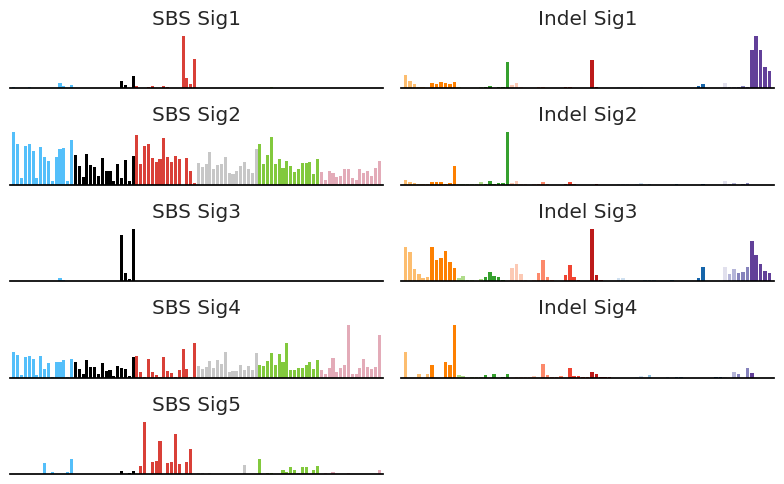

In [45]:
# "Indel83" is a constant from sal.consts
model.plot_signatures(colors={"Indel": "Indel83"})

The results of an individual modality can of course still be plotted using the explicit API.

array([[<Axes: title={'center': 'Indel Sig1'}>,
        <Axes: title={'center': 'ID6'}>],
       [<Axes: title={'center': 'Indel Sig2'}>,
        <Axes: title={'center': 'ID1'}>],
       [<Axes: title={'center': 'Indel Sig3'}>,
        <Axes: title={'center': 'ID8'}>],
       [<Axes: title={'center': 'Indel Sig4'}>,
        <Axes: title={'center': 'ID2'}>]], dtype=object)

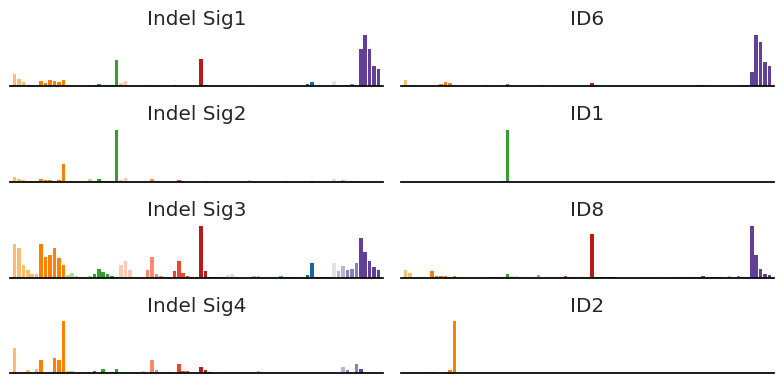

In [46]:
sal.pl.barplot(
    model.asignatures["Indel"],
    colors="Indel83",
    catalog=catalog_indel
)

array([<Axes: title={'center': 'SBS signature exposures'}>,
       <Axes: title={'center': 'Indel signature exposures'}>],
      dtype=object)

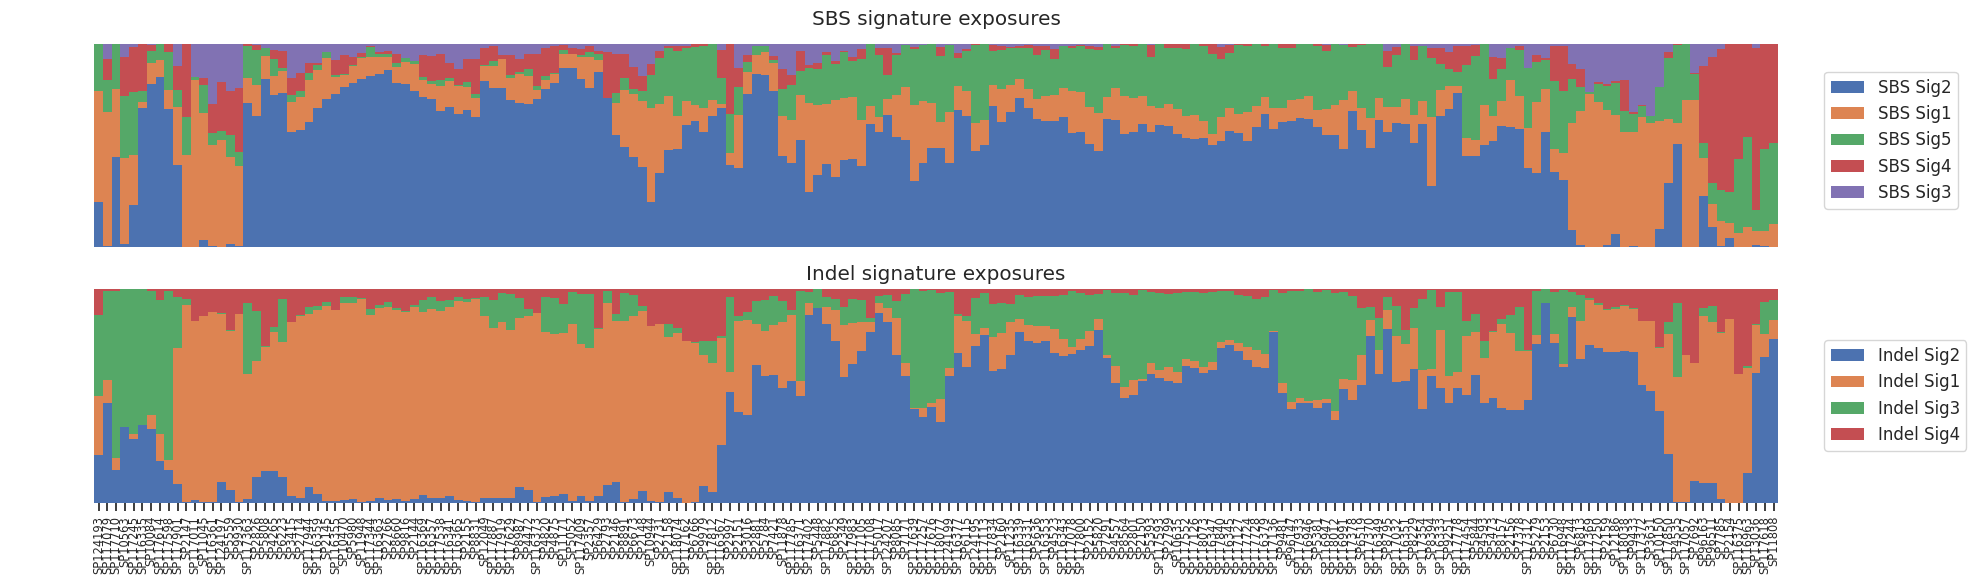

In [47]:
# samples are ordered jointly
model.plot_exposures()

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

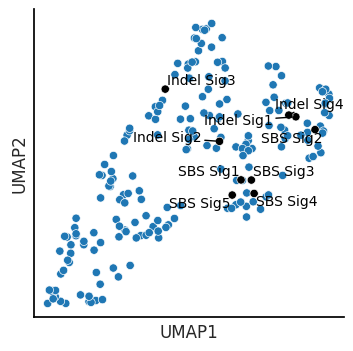

In [48]:
# not converged yet
model.plot_embeddings(adjust_kwargs={"arrowprops": dict(arrowstyle="-", color='k')})

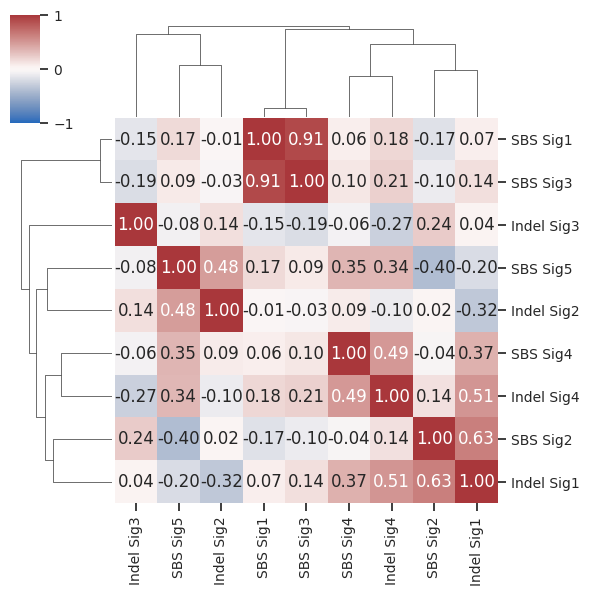

In [49]:
model.plot_correlation(figsize=(6, 6))

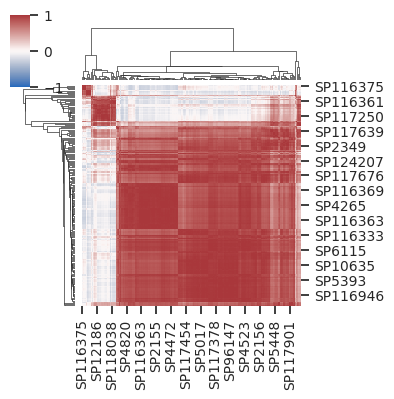

In [50]:
model.plot_correlation(data="samples")

## 2.4 Fixing a priori known signatures

Fixing arbitrary many known signatures is also supported for multimodal correlated NMF. Again, however, only learning a subset of the signatures might cause the algorithm to get stuck in poor local optima. We recommend to track the objective function values and to compare them to runs where no signatures are fixed.

In [51]:
known_signatures_sbs = catalog_sbs.loc[["SBS1", "SBS13"]]
known_signatures_indel = catalog_indel.loc[["ID6"]]

given_parameters = {
    "SBS": {"asignatures": ad.AnnData(known_signatures_sbs)},
    "Indel": {"asignatures": ad.AnnData(known_signatures_indel)},
}

array([[<Axes: title={'center': 'SBS1'}>,
        <Axes: title={'center': 'ID6'}>],
       [<Axes: title={'center': 'SBS13'}>,
        <Axes: title={'center': 'Indel Sig1'}>],
       [<Axes: title={'center': 'SBS Sig1'}>,
        <Axes: title={'center': 'Indel Sig2'}>],
       [<Axes: title={'center': 'SBS Sig2'}>, <Axes: >]], dtype=object)

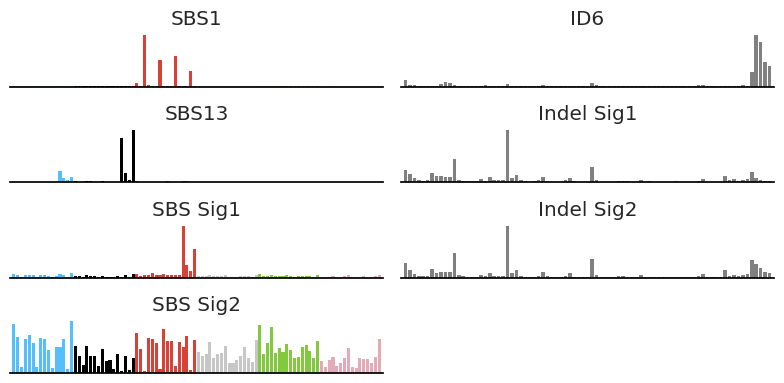

In [52]:
model = sal.models.MultimodalCorrNMF(
    ns_signatures=[4,3],
    dim_embeddings=6,
    init_method="random",
    max_iterations=10,
)
model.fit(
    mdata.copy(),
    given_parameters=given_parameters,
    init_kwargs={"seed": 42}
)
model.plot_signatures()

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

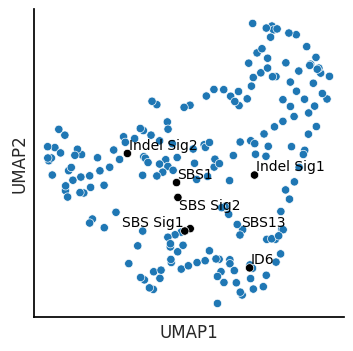

In [53]:
model.plot_embeddings()